# 1-Packages

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import norm
from statsmodels.stats.stattools import jarque_bera

# 11-Importation et préparation des données soi.tsv

In [5]:
# Vérifier l'apparence du fichier
with open("soi.tsv", "r",encoding="latin-1") as f:
    content = f.read()
print(content)

1.53716	0.922168	-0.104204	-0.291903	-0.658745	0.172287	-1.01062	-0.224433	-1.07643	-0.972327	-0.770102	-0.740707	-0.891187	-0.603337	0.521818	-0.249924	0.754485	0.744746	0.493	0.0511044	-0.214278	0.386053	0.002948	-1.21634	0.284623	-0.498785	-0.170639	0.196599	-1.69189	0.101991	-0.000650392	-1.18599	-1.24613	0.0530912	-0.286749	-0.462596	0.685307	-0.284534	0.261726	0.640549	0.489245	0.104565	0.393598	1.0791	0.163238	0.26863	0.145616	1.37914	-0.536842	1.90432	0.649539	-0.124778	1.03389	1.30097	1.58099	1.45919	1.30093	1.5186	1.23618	0.990039	1.32935	1.62363	1.34328	0.90064	1.41269	1.08157	1.10536	1.19009	0.0625472	1.78126	0.150765	1.06935	0.611149	-0.0586977	0.206876	0.242439	-0.663894	0.155554	0.226473	-0.493534	-0.923468	0.0440809	-0.988215	-0.296758	-1.87849	-0.496211	0.256578	0.357288	-0.485185	0.274264	0.393598	0.920983	-0.31368	0.0685367	-0.443576	-0.625858	-0.883464	-1.37381	1.28972	0.410851	0.485384	-0.116122	-0.263316	-0.11602	0.00254869	0.485456	0.913518	0.902221	0.129083	0.09

In [6]:
# Importer le fichier en csv
path = "soi.tsv"

df = pd.read_csv(
    path,
    header = None, 
    sep = '\t',

)

s = df.stack().reset_index(drop=True)   # <- IMPORTANT: drop=True
s.name = "Southern_oscillation"

In [7]:
# Présence de nan
print(s.dtypes)
print(s.isnull().sum())

float64
0


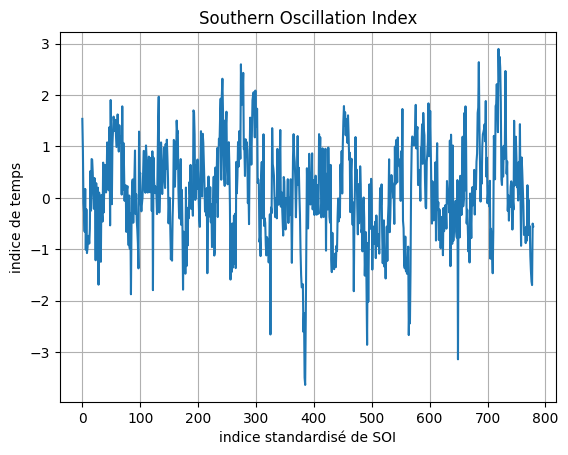

In [8]:
# Plotter la série temporelle
plt.figure()
s.plot()
plt.title("Southern Oscillation Index")
plt.xlabel("indice standardisé de SOI")
plt.ylabel("indice de temps")
plt.grid(True)

Le SOI mesure comment la pression de l'air varie entre Tahiti et Darwin : 
- Autour de 0, la pression est neutre. 
- Quand l’écart de pression est plus grand que la normale → on est en tendance La Niña.
- Quand l’écart est plus petit que la normale (ou inversé) → on est en tendance El Niño.

Vu que c'est une variable temporelle de croissance, la tendance elle est constante. Vérifions maintenant si c'est stationnaire. 

# 2. Analyse de l'autocorrélation

In [9]:
# Test de stationnarité
s_adfuller = adfuller(s)
print(s_adfuller)
s_adfuller_p_value = s_adfuller[1]
print(s_adfuller_p_value)
if s_adfuller_p_value < 0.05 : 
    print("on rejette H0, la série est stationnaire")
else : 
    print("il n'y a pas suffisamment de preuve pour rejetter H0")

(np.float64(-7.502543292317648), np.float64(4.21630297019212e-11), 2, 777, {'1%': np.float64(-3.4387940607132887), '5%': np.float64(-2.8652669182555943), '10%': np.float64(-2.5687545755297494)}, np.float64(1610.2252214204245))
4.21630297019212e-11
on rejette H0, la série est stationnaire


Nous pouvons donc passer à l'analyse de l'autocorrélation

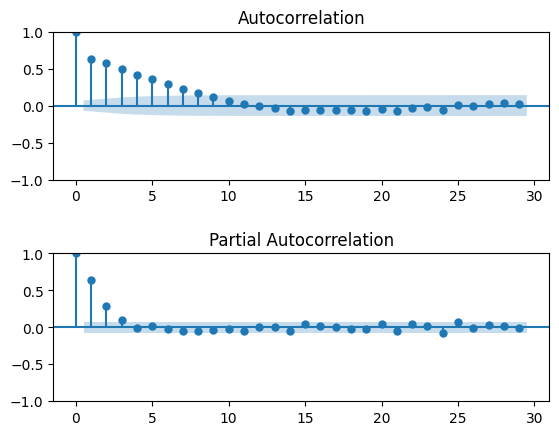

In [10]:
# ACF et PACF
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
plot_acf(s, ax=ax1) 
ax2 = fig.add_subplot(2,1,2)
plot_pacf(s, ax=ax2)
plt.subplots_adjust(hspace=0.5)
plt.show()

L'autoccorélation mesure l'intensité de relation entre le lags. Le partical autocorrélation mesure toujours cette intensité mais corrigé des cumuls des autres relations. 

Nous venons de voir que la série temporelle présente environ 09 nombre de retards qui sont liés entre eux. Ce qui signifie qu'un modèle auto-régressif est idéal pour modéliser SOI. Le nombre retards optimal peut être entre 1 à 4. 

Nous allons appliquer : 
- AR
- ARIMA
- ARCH
- GARCH

# Split des données et préparation des paramètres

In [11]:
print(s.dtype)

float64


In [12]:
n = len(s)
print(n)
h = 0.2 * n
h = int(h)
print(h)
y_train, y_test = s.iloc[:-h], s.iloc[-h:]
idx_train, idx_test = y_train.index, y_test.index
p_max = 4 # p_max représente la valeur maximale de retards pris par le modèle. Elle ne dépasse pas 4 selon le PACF()
k = 5 # Nombre d'échantillon de backtesting

780
156


# Modèle AR()

## Choix de p Avec AIC et BIC

In [45]:
# AIC
def ts_cv_rmse_ar_aic(s, p_max, nchunks):
    s = pd.Series(s)
    n = len(s)
    cuts = np.unique(np.linspace(0, n, nchunks + 1, dtype=int))

    best_p, best_aic = None, np.inf

    # --- sélectionner p selon AIC sur toute la série
    for p in range(1, min(p_max, n - 1) + 1):
        try:
            res = AutoReg(s, lags=p, old_names=False).fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_p = p
        except:
            continue

    # --- ensuite, CV avec p choisi
    rmse = []
    for k in range(len(cuts) - 2):
        train = s.iloc[:cuts[k+1]]
        validation = s.iloc[cuts[k+1]:cuts[k+2]]

        if len(validation) == 0 or len(train) <= best_p:
            rmse.append(np.nan)
            continue

        try:
            model = AutoReg(train, lags=best_p, old_names=False).fit()
            pred = pd.Series(model.forecast(len(validation)), index=validation.index)
            rmse_fold = float(np.sqrt(((validation - pred) ** 2).mean()))
            rmse.append(rmse_fold)
        except:
            rmse.append(np.nan)

    return best_p, float(np.nanmean(rmse)) if rmse else np.nan


In [49]:
# BIC
def ts_cv_rmse_ar_bic(s, p_max, nchunks):
    s = pd.Series(s)
    n = len(s)
    cuts = np.unique(np.linspace(0, n, nchunks + 1, dtype=int))

    best_p, best_bic = None, np.inf

    # --- sélectionner p selon BIC sur toute la série
    for p in range(1, min(p_max, n - 1) + 1):
        try:
            res = AutoReg(s, lags=p, old_names=False).fit()
            if res.bic < best_bic:
                best_bic = res.bic
                best_p = p
        except:
            continue

    # --- ensuite, CV avec p choisi
    rmse = []
    for k in range(len(cuts) - 2):
        train = s.iloc[:cuts[k+1]]
        validation = s.iloc[cuts[k+1]:cuts[k+2]]

        if len(validation) == 0 or len(train) <= best_p:
            rmse.append(np.nan)
            continue

        try:
            model = AutoReg(train, lags=best_p, old_names=False).fit()
            pred = pd.Series(model.forecast(len(validation)), index=validation.index)
            rmse_fold = float(np.sqrt(((validation - pred) ** 2).mean()))
            rmse.append(rmse_fold)
        except:
            rmse.append(np.nan)

    return best_p, float(np.nanmean(rmse)) if rmse else np.nan


In [50]:
p_aic, cv_rmse_aic = ts_cv_rmse_ar_aic(s, p_max=4, nchunks=5)
print(f"AIC → p*={p_aic}, CV_RMSE={cv_rmse_aic:.4f}")

p_bic, cv_rmse_bic = ts_cv_rmse_ar_bic(s, p_max=4, nchunks=5)
print(f"BIC → p*={p_bic}, CV_RMSE={cv_rmse_bic:.4f}")

AIC → p*=4, CV_RMSE=1.0003
BIC → p*=3, CV_RMSE=0.9985


Si on se réfère à AIC et BIC, on peut choisir p = 3 ou 4. PACF confirme plutôt le p = 3.  

## Entrainement de AR(3) et validation

In [56]:
# Entrainement
best_model_ar = AutoReg(endog = y_train, lags = 3)
best_model_ar_resid = best_model_ar.fit()
print(best_model_ar_resid.summary())

                             AutoReg Model Results                              
Dep. Variable:     Southern_oscillation   No. Observations:                  624
Model:                       AutoReg(3)   Log Likelihood                -641.119
Method:                 Conditional MLE   S.D. of innovations              0.679
Date:                  Sun, 07 Sep 2025   AIC                           1292.239
Time:                          17:52:05   BIC                           1314.396
Sample:                               3   HQIC                          1300.851
                                    624                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0201      0.027      0.732      0.464      -0.034       0.074
Southern_oscillation.L1     0.4600      0.040     11.508      0.000       0.

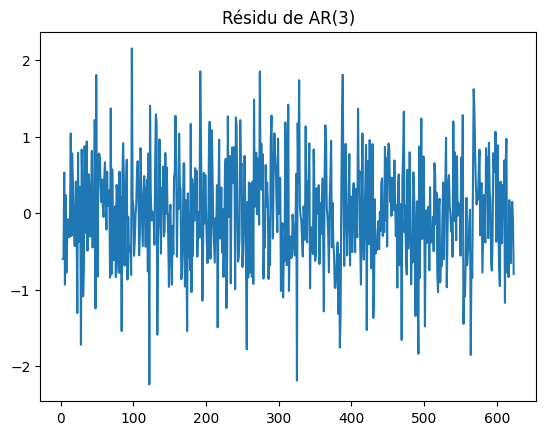

In [58]:
# Analyse de residu
ar_resid = best_model_ar_resid.resid

plt.figure()
plt.plot(ar_resid)
plt.title("Résidu de AR(3)")
plt.show()

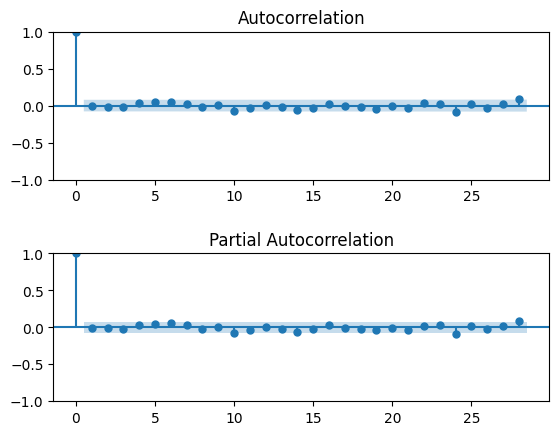

In [79]:
fig = plt.figure()

ax1 = fig.add_subplot(2,1,1)
plot_acf(ar_resid, ax=ax1)

ax2 = fig.add_subplot(2,1,2)
plot_pacf(ar_resid, ax=ax2)

plt.subplots_adjust(hspace=0.5)

plt.show()

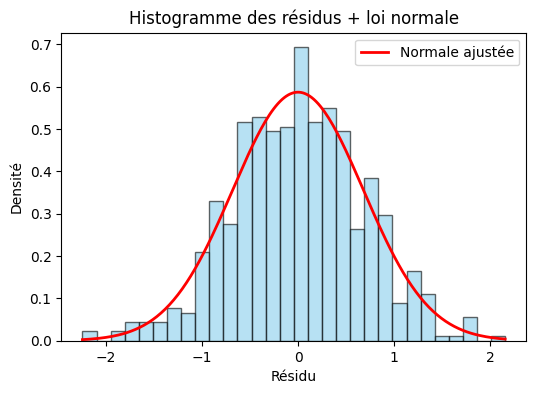

In [63]:
# 2. Histogramme + densité normale ajustée
mu, sigma = ar_resid.mean(), ar_resid.std()

plt.figure(figsize=(6,4))
plt.hist(ar_resid, bins=30, density=True, alpha=0.6, color="skyblue", edgecolor="black")
x = np.linspace(ar_resid.min(), ar_resid.max(), 200)
plt.plot(x, norm.pdf(x, mu, sigma), "r-", lw=2, label="Normale ajustée")
plt.title("Histogramme des résidus + loi normale")
plt.xlabel("Résidu")
plt.ylabel("Densité")
plt.legend()
plt.show()

Normalement, le résidu ne contient plus l'autocorrélation puisque ACF et PACF montre une chutte brutale de lags 0 à 1. S'agissant de la distribution de résidu, elle suit une loi normale graphiquement. Essayons de vérifier par des tests.

In [73]:
# Test Ljung-Box pour l'autocorrélation
lb_test = acorr_ljungbox(ar_resid, lags=[3], return_df=True)
print(lb_test)

# Test de Jarque_bera pour la normalité
jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(ar_resid)

print(f"Jarque-Bera statistic : {jb_stat:.3f}")
print(f"p-value              : {jb_pvalue:.3f}")
print(f"Asymétrie (skewness) : {skew:.3f}")
print(f"Kurtosis             : {kurtosis:.3f}")

    lb_stat  lb_pvalue
3  0.469558   0.925527
Jarque-Bera statistic : 0.868
p-value              : 0.648
Asymétrie (skewness) : -0.037
Kurtosis             : 3.168


In [74]:
# --- Commentaire automatique ---
if lb_test["lb_pvalue"].iloc[-1] > 0.05:
    print("Résidus ~ bruit blanc (pas d'autocorrélation).")
else:
    print("Résidus autocorrélés (modèle à améliorer).")

if jb_pvalue > 0.05:
    print("Résidus ~ distribution normale.")
else:
    print("Résidus non normaux (asymétrie/kurtosis anormale).")

Résidus ~ bruit blanc (pas d'autocorrélation).
Résidus ~ distribution normale.


## Prévision avec AR

In [83]:
# --- Prévisions sur la partie test ---
y_pred = best_model_ar_resid.predict(
    start=len(y_train), 
    end=len(y_train) + len(y_test) - 1, 
    dynamic=False
)

RMSE AR(3) rolling = 0.7458


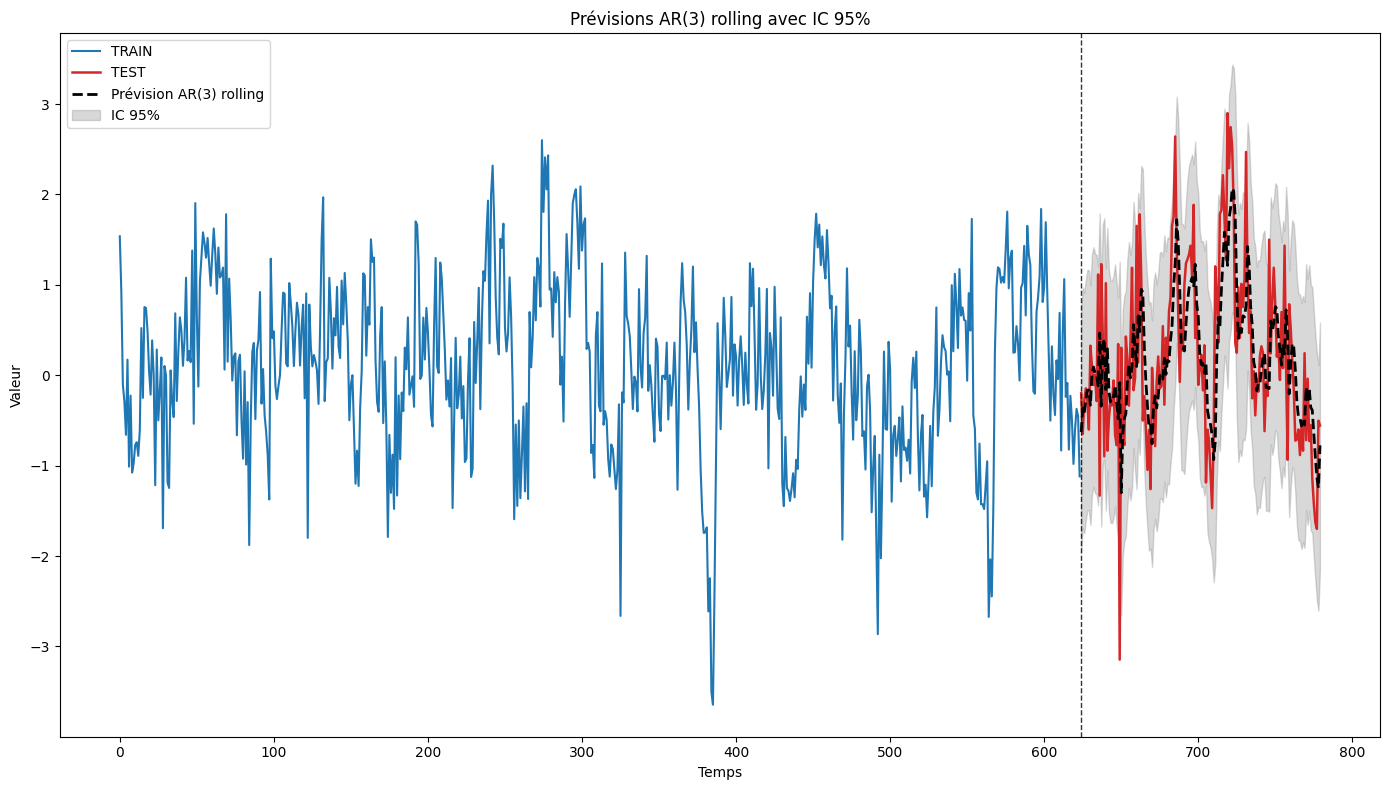

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

# --- Prévision rolling (walk-forward) ---
history = list(y_train)
rolling_preds = []
conf_low = []   # <-- corrige l'initialisation
conf_high = []  # <--

z = 1.96  # IC 95%

for t in range(len(y_test)):
    model = AutoReg(history, lags=3, old_names=False).fit()
    yhat = model.predict(start=len(history), end=len(history), dynamic=False)

    # récupère la prévision 1-pas (ndarray ou Series possible selon la version)
    yhat_val = yhat[0] if isinstance(yhat, (np.ndarray, list)) else yhat.iloc[0]
    rolling_preds.append(yhat_val)

    # Intervalle de confiance (approximation : ±1.96 * sigma des innovations)
    sigma = np.sqrt(model.sigma2)
    conf_low.append(yhat_val - z * sigma)
    conf_high.append(yhat_val + z * sigma)

    # on ajoute la vraie valeur au "train"
    history.append(y_test.iloc[t])

rolling_preds = pd.Series(rolling_preds, index=y_test.index)
conf_low = pd.Series(conf_low, index=y_test.index)
conf_high = pd.Series(conf_high, index=y_test.index)

# --- RMSE ---
rmse_rolling = np.sqrt(mean_squared_error(y_test, rolling_preds))
print(f"RMSE AR(3) rolling = {rmse_rolling:.4f}")

# --- Graphique ---
plt.figure(figsize=(14,8))
plt.plot(y_train.index, y_train.values, color="tab:blue", linewidth=1.5, label="TRAIN")
plt.plot(y_test.index, y_test.values, color="tab:red", linewidth=1.8, label="TEST")
plt.plot(y_test.index, rolling_preds.values, color="black", linewidth=2, linestyle="--", label="Prévision AR(3) rolling")
plt.fill_between(y_test.index, conf_low.values, conf_high.values, color="gray", alpha=0.3, label="IC 95%")
plt.axvline(y_test.index[0], linestyle="--", linewidth=1, color="black", alpha=0.8)
plt.title("Prévisions AR(3) rolling avec IC 95%")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

RMSE AR(3) rolling = 0.7458


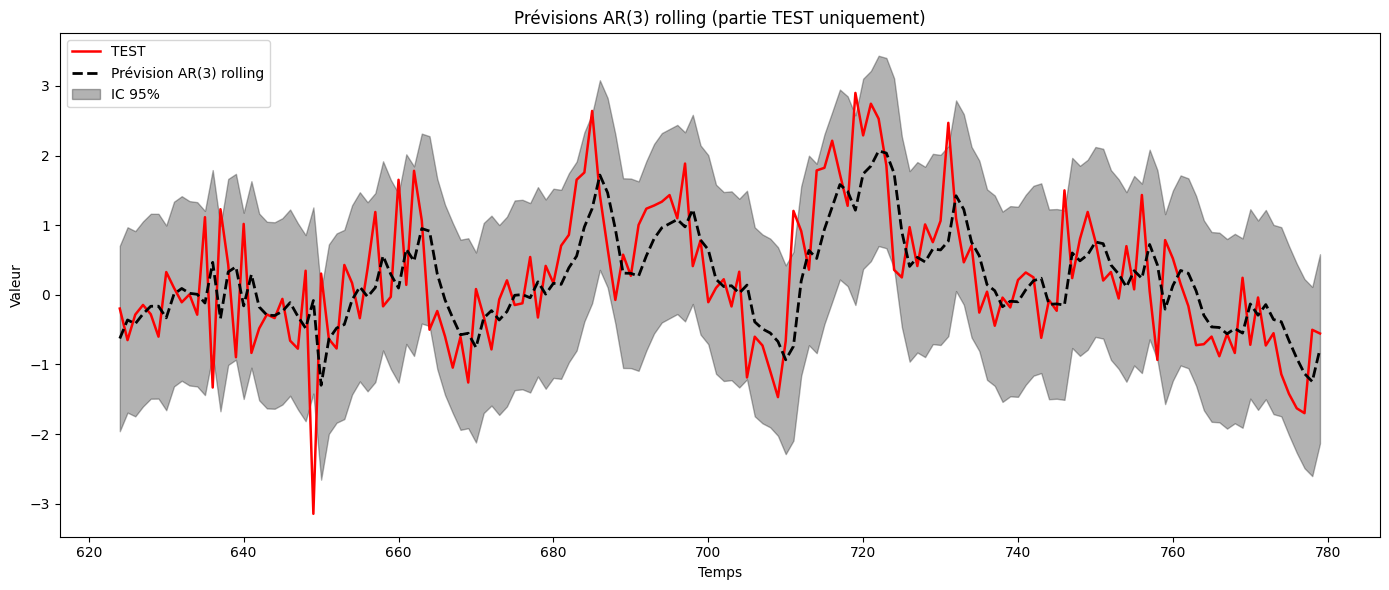

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

# --- Prévision rolling (walk-forward) ---
history = list(y_train)
rolling_preds = []
conf_low = []
conf_high = []

z = 1.96  # IC 95%

for t in range(len(y_test)):
    model = AutoReg(history, lags=3, old_names=False).fit()
    yhat = model.predict(start=len(history), end=len(history), dynamic=False)

    yhat_val = yhat[0] if isinstance(yhat, (np.ndarray, list)) else yhat.iloc[0]
    rolling_preds.append(yhat_val)

    sigma = np.sqrt(model.sigma2)
    conf_low.append(yhat_val - z * sigma)
    conf_high.append(yhat_val + z * sigma)

    history.append(y_test.iloc[t])

rolling_preds = pd.Series(rolling_preds, index=y_test.index)
conf_low = pd.Series(conf_low, index=y_test.index)
conf_high = pd.Series(conf_high, index=y_test.index)

# --- RMSE ---
rmse_rolling = np.sqrt(mean_squared_error(y_test, rolling_preds))
print(f"RMSE AR(3) rolling = {rmse_rolling:.4f}")

# --- Graphique limité au test ---
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test.values, color="red", linewidth=1.8, label="TEST")
plt.plot(y_test.index, rolling_preds.values, color="black", linewidth=2, linestyle="--", label="Prévision AR(3) rolling")
plt.fill_between(y_test.index, conf_low.values, conf_high.values, color="black", alpha=0.3, label="IC 95%")
plt.title("Prévisions AR(3) rolling (partie TEST uniquement)")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.legend(loc="upper left", facecolor="white")
plt.tight_layout()
plt.show()